
Import Libraries


In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns

Load Dataset

In [3]:

def load_dataset():
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    return pd.read_csv(file_name)

# Load data
data = load_dataset()


print("Dataset Shape:", data.shape)
print("\nFeature Names:")
print(data.columns.tolist())


# Display target distribution
print("\nTarget Variable Distribution:")
print(data['Electric Vehicle Type'].value_counts())

Saving ev_data_normalized.csv to ev_data_normalized.csv
Dataset Shape: (220225, 13)

Feature Names:
['Model Year', 'Electric Range', 'Longitude', 'Latitude', 'County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Utility', 'Legislative District']

Target Variable Distribution:
Electric Vehicle Type
0.0    174212
1.0     46013
Name: count, dtype: int64


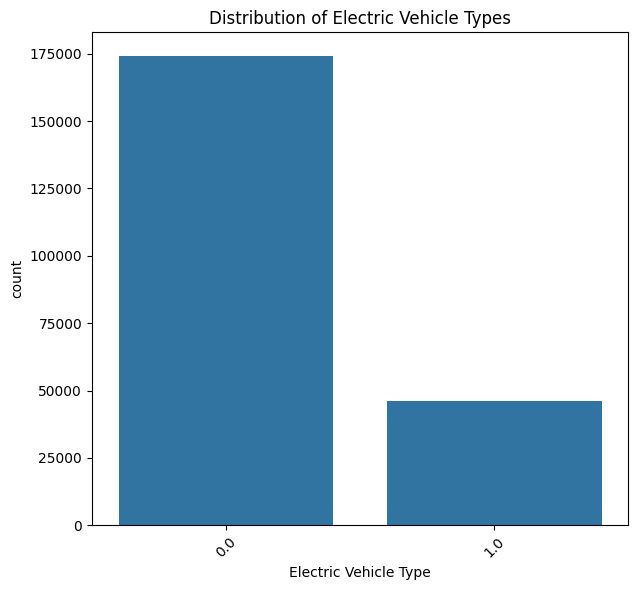

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Electric Vehicle Type')
plt.title('Distribution of Electric Vehicle Types')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Data Preparation**

In [5]:

def prepare_data(df, target_column, test_size=0.2):
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns


**Model training**

In [6]:
def train_and_evaluate_models(data, target_column):


    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    solvers = ['lbfgs', 'saga']
    results = []

    # Get number of unique classes
    n_classes = data[target_column].nunique()

    # Train and evaluate models with different parameters
    for C in C_values:
        for solver in solvers:
            try:

                log_reg = LogisticRegression(
                    C=C,
                    solver=solver,
                    max_iter=1000
                )

                # Prepare data
                X_train_scaled, X_test_scaled, y_train, y_test, _ = prepare_data(
                    data, target_column
                )

                # Train and evaluate
                log_reg.fit(X_train_scaled, y_train)
                y_pred = log_reg.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_pred)

                # Store results
                results.append({
                    'C': C,
                    'solver': solver,
                    'accuracy': accuracy
                })

            except Exception as e:
                print(f"Error with C={C}, solver={solver}: {str(e)}")
                continue

    results_df = pd.DataFrame(results)

    if results_df.empty:
        raise ValueError("No successful models were trained. Please check your data and parameters.")

    return results_df

# Run model training and evaluation
results_df = train_and_evaluate_models(data, "Electric Vehicle Type")
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
          C solver  accuracy
0     0.001  lbfgs  0.871336
1     0.001   saga  0.871336
2     0.010  lbfgs  0.872608
3     0.010   saga  0.872630
4     0.100  lbfgs  0.872199
5     0.100   saga  0.872199
6     1.000  lbfgs  0.872244
7     1.000   saga  0.872222
8    10.000  lbfgs  0.872244
9    10.000   saga  0.872199
10  100.000  lbfgs  0.872244
11  100.000   saga  0.872199


Performance visualization

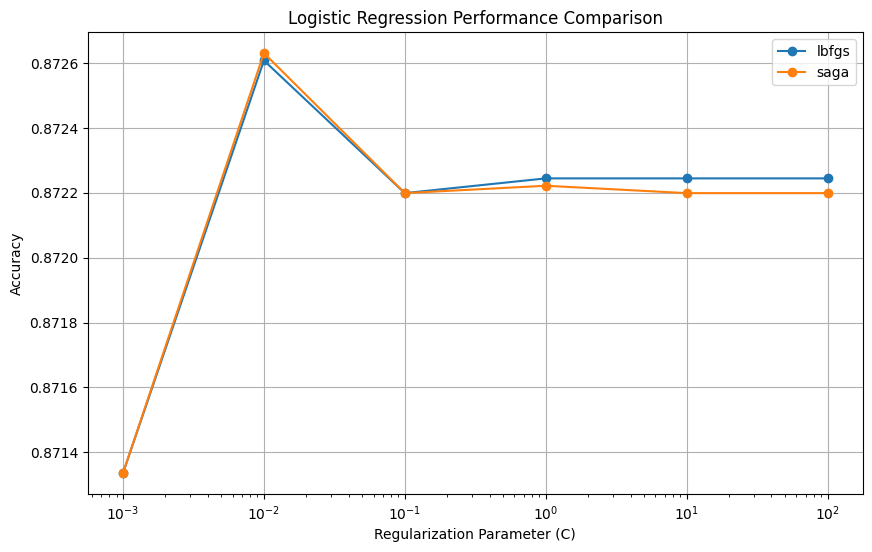

In [7]:

def plot_model_performance(results_df):

    plt.figure(figsize=(10, 6))

    for solver in results_df['solver'].unique():
        solver_results = results_df[results_df['solver'] == solver]
        plt.semilogx(
            solver_results['C'],
            solver_results['accuracy'],
            marker='o',
            label=solver
        )

    plt.xlabel('Regularization Parameter (C)')
    plt.ylabel('Accuracy')
    plt.title('Logistic Regression Performance Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot performance comparison
plot_model_performance(results_df)

In [8]:
def train_best_model(data, target_column, results_df):

    # Get best parameters
    best_params = results_df.loc[results_df['accuracy'].idxmax()]
    best_C = best_params['C']
    best_solver = best_params['solver']

    print(f"\nBest parameters: C={best_C}, solver={best_solver}")

    # Train best model
    X_train_scaled, X_test_scaled, y_train, y_test, feature_names = prepare_data(
        data, target_column
    )

    best_model = LogisticRegression(
        C=best_C,
        solver=best_solver,
        max_iter=1000,
        multi_class='multinomial'
    )

    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, digits=8)

    print("\nBest Model Performance:")
    print(f"Accuracy: {accuracy}")
    print("\nClassification Report:")
    print(class_report)

    return best_model, feature_names, y_test, y_pred

# Train and evaluate best model
best_model, feature_names, y_test, y_pred = train_best_model(
    data, "Electric Vehicle Type", results_df
)



Best parameters: C=0.01, solver=saga


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(



Best Model Performance:
Accuracy: 0.8724032239754796

Classification Report:
              precision    recall  f1-score   support

         0.0  0.88048266 0.97030357 0.92321355     34819
         1.0  0.81776524 0.50292651 0.62281879      9226

    accuracy                      0.87240322     44045
   macro avg  0.84912395 0.73661504 0.77301617     44045
weighted avg  0.86734539 0.87240322 0.86029059     44045



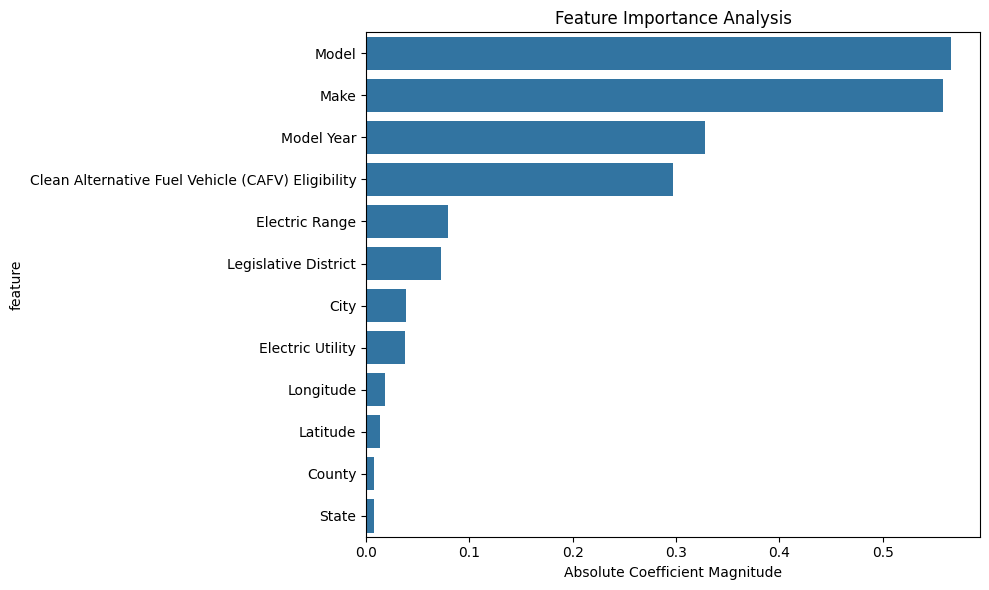


Top 5 Most Important Features:
                                             feature  importance
8                                              Model    0.565911
7                                               Make    0.558661
0                                         Model Year    0.327903
9  Clean Alternative Fuel Vehicle (CAFV) Eligibility    0.297396
1                                     Electric Range    0.079425


In [9]:
def plot_feature_importance(model, feature_names):

    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.mean(np.abs(model.coef_), axis=0)
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature')
    plt.title('Feature Importance Analysis')
    plt.xlabel('Absolute Coefficient Magnitude')
    plt.tight_layout()
    plt.show()

    # Print top features
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())

# Analyze feature importance
plot_feature_importance(best_model, feature_names)

Class labels in the dataset: ['0.0', '1.0']

Detailed Model Performance Metrics:
      C solver   accuracy precision_0.0 recall_0.0     f1_0.0 precision_1.0 recall_1.0     f1_1.0
  0.001  lbfgs 0.87133613    0.87640740 0.97469772 0.92294304    0.83442962 0.48124865 0.61043514
  0.001   saga 0.87133613    0.87640740 0.97469772 0.92294304    0.83442962 0.48124865 0.61043514
  0.010  lbfgs 0.87260756    0.88031250 0.97084925 0.92336689    0.82019486 0.50184262 0.62268845
  0.010   saga 0.87263026    0.88031562 0.97087797 0.92338159    0.82034018 0.50184262 0.62273033
  0.100  lbfgs 0.87219889    0.88057366 0.96987277 0.92306851    0.81580334 0.50357685 0.62274646
  0.100   saga 0.87219889    0.88057366 0.96987277 0.92306851    0.81580334 0.50357685 0.62274646
  1.000  lbfgs 0.87224430    0.88063944 0.96984405 0.92309164    0.81575715 0.50390202 0.62298157
  1.000   saga 0.87219889    0.88059351 0.96984405 0.92306641    0.81569247 0.50368524 0.62279702
 10.000  lbfgs 0.87224430    0.880639

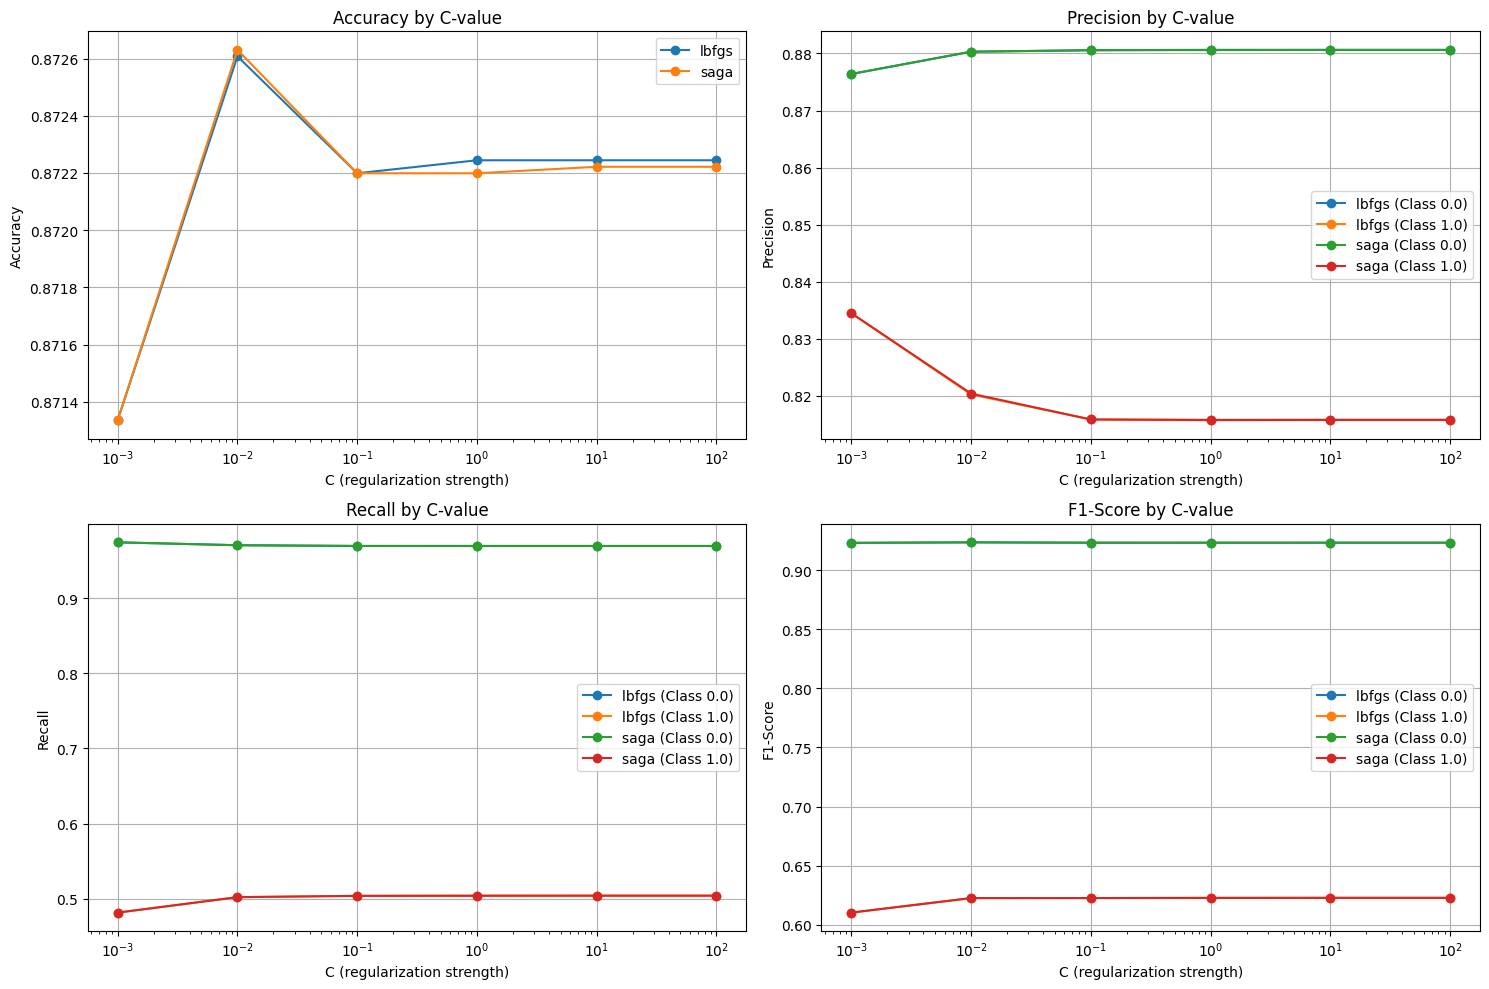

In [13]:
# Generate detailed metrics for different parameters
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define parameter combinations
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
solvers = ['lbfgs', 'saga']
detailed_results = []

# Generate detailed metrics for each parameter combination
for C in C_values:
    for solver in solvers:
        # Initialize model
        log_reg = LogisticRegression(
            C=C,
            solver=solver,
            max_iter=1000,
            random_state=42
        )

        # Prepare data and fit model
        X_train_scaled, X_test_scaled, y_train, y_test, feature_names = prepare_data(data, "Electric Vehicle Type")
        log_reg.fit(X_train_scaled, y_train)
        y_pred = log_reg.predict(X_test_scaled)


        report = classification_report(y_test, y_pred, output_dict=True)


        class_labels = [label for label in report.keys()
                       if label not in ['accuracy', 'macro avg', 'weighted avg']]


        result = {
            'C': C,
            'solver': solver,
            'accuracy': f"{report['accuracy']:.8f}"
        }

        # Add class-specific metrics
        for label in class_labels:
            result.update({
                f'precision_{label}': f"{report[label]['precision']:.8f}",
                f'recall_{label}': f"{report[label]['recall']:.8f}",
                f'f1_{label}': f"{report[label]['f1-score']:.8f}"
            })

        detailed_results.append(result)


results_df = pd.DataFrame(detailed_results)

# Print class labels found
print("Class labels in the dataset:", class_labels)

# Display the results
print("\nDetailed Model Performance Metrics:")
print(results_df.to_string(index=False))


table_data = []
for idx, row in results_df.iterrows():
    formatted_row = {
        'Model': idx + 1,
        'Solver': row['solver'],
        'C': row['C'],
        'Accuracy': float(row['accuracy']),
        'Precision': np.mean([float(row[f'precision_{label}']) for label in class_labels]),
        'Recall': np.mean([float(row[f'recall_{label}']) for label in class_labels]),
        'F1-Score': np.mean([float(row[f'f1_{label}']) for label in class_labels])
    }
    table_data.append(formatted_row)

presentation_table = pd.DataFrame(table_data)
print("\nFormatted Table:")
print(presentation_table.round(8).to_string(index=False))


plt.figure(figsize=(15, 10))
for solver in solvers:
    solver_results = results_df[results_df['solver'] == solver]

    plt.subplot(2, 2, 1)
    plt.semilogx(solver_results['C'], solver_results['accuracy'].astype(float),
             marker='o', label=f'{solver}')
    plt.title('Accuracy by C-value')
    plt.xlabel('C (regularization strength)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Plot class-specific metrics
    for label in class_labels:
        plt.subplot(2, 2, 2)
        plt.semilogx(solver_results['C'], solver_results[f'precision_{label}'].astype(float),
                 marker='o', label=f'{solver} (Class {label})')
        plt.title('Precision by C-value')
        plt.xlabel('C (regularization strength)')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.semilogx(solver_results['C'], solver_results[f'recall_{label}'].astype(float),
                 marker='o', label=f'{solver} (Class {label})')
        plt.title('Recall by C-value')
        plt.xlabel('C (regularization strength)')
        plt.ylabel('Recall')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.semilogx(solver_results['C'], solver_results[f'f1_{label}'].astype(float),
                 marker='o', label=f'{solver} (Class {label})')
        plt.title('F1-Score by C-value')
        plt.xlabel('C (regularization strength)')
        plt.ylabel('F1-Score')
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()